## 1. PM лог

### Представленные данные являются журналом событий информационной системы, управляющей штрафами за нарушение правил дорожного двивжения.

## 2. EDA PM лога

### **Основные характеристики лога:**
* **Экземпляры** - 150370
* **Операции** - 561470
* **Уникальные операции** - 11
* **Средняя длительность** - 341д 16ч 13м
* **Начало процесса** - 01.01.2000
* **Конец процесса** - 18.06.2013
* **Вариативность путей** - 0.2%

### **Уникальные операции:**
* **Create Fine** - Создание штрафа
* **Send Fine** - Отправление штрафа
* **Insert Fine Notification** - Вставить уведомление о штрафе
* **Add penalty** - Начислить пеню (Назначить дополнительное наказание)
* **Payment** - Оплата
* **Send for Credit Collection** - Направить для взыскания задолжности
* **Insert Date Appeal to Prefecture** - Указание даты обжалования в префектуре
* **Send Appeal to Prefecture** - Направление обжалования в префектуру
* **Receive Result Appeal to Offender** - Получение решения обжалования из префектуры
* **Notify Result Appeal to Offender** - Уведомление нарушителя о решении обжалования
* **Appeal to Judge** - Обжалование в суде

### Ключевые столбцы:
* **case:concept:name** - столбец экземпляров
* **concept:name** - столбец операций
* **time:timestamp** - время начала операций 

In [90]:
import pandas as pd
import pm4py
import json
import os
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.log import EventLog, Trace, Event
from pm4py.objects.log.exporter.xes.variants import etree_xes_exp as exporter
import numpy as np
from math import sqrt
import pytz
from datetime import datetime

from sklearn.metrics import mean_squared_error, precision_score, recall_score, mean_absolute_error
from scipy.spatial import distance

from import_data import read_data_equisize, read_data_equitemp, determine_cutoff_point, ActivityPair
from forecasting import ARf, ARIMAf, HWf, NAVf, GARCHf
from operations import calculate_entropic_relevance

import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [3]:
############
# Параметры используемые в исследовании:
dataset = 'RTFMP'
agg_type = 'months' # возможен параметр 'equisize'

In [5]:
# Загрузка лога
variant = xes_importer.Variants.ITERPARSE
paras = {variant.value.Parameters.MAX_TRACES: 1000000000}
log = xes_importer.apply(dataset + '.xes', parameters=paras)

parsing log, completed traces :: 100%|███████████████████████████████████████| 150370/150370 [00:24<00:00, 6064.52it/s]


In [6]:
# Преобразование в Датафрейм для просмотра пустот и дубликатов
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
import pandas as pd

# Преобразование XES в DataFrame
data_frame = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

### Обзор лога

In [26]:
data_frame[['concept:name', 'time:timestamp', 'case:concept:name']].head(10)

,concept:name,time:timestamp,case:concept:name
0,Create Fine,2006-07-24 00:00:00+02:00,A1
1,Send Fine,2006-12-05 00:00:00+01:00,A1
2,Create Fine,2006-08-02 00:00:00+02:00,A100
3,Send Fine,2006-12-12 00:00:00+01:00,A100
4,Insert Fine Notification,2007-01-15 00:00:00+01:00,A100


In [28]:
# Проверка на пустые значения в ключевых столбцах
print(data_frame[['concept:name', 'time:timestamp', 'case:concept:name']].isnull().sum())

concept:name         0
time:timestamp       0
case:concept:name    0
dtype: int64


In [30]:
# Проверка на дубли
dubl = data_frame[data_frame.duplicated(subset=['concept:name', 'time:timestamp', 'case:concept:name'])]
dubl[['concept:name', 'time:timestamp', 'case:concept:name']]

,concept:name,time:timestamp,case:concept:name
5084,Payment,2008-09-22 00:00:00+02:00,A12292
21391,Payment,2008-11-05 00:00:00+01:00,A20114
21392,Payment,2008-11-05 00:00:00+01:00,A20114
24179,Payment,2008-09-30 00:00:00+02:00,A21397
24559,Payment,2008-02-21 00:00:00+01:00,A21568
26880,Payment,2008-08-26 00:00:00+02:00,A22688
35948,Payment,2009-12-10 00:00:00+01:00,A27247
50715,Payment,2009-08-20 00:00:00+02:00,A34677
51115,Payment,2010-06-23 00:00:00+02:00,A34878
80641,Payment,2008-09-26 00:00:00+02:00,A9983


## 3. Преобразование PM лога во временной ряд

In [7]:
# Кодируем стадии как числа
activity_names = pm4py.get_attribute_values(log, 'concept:name')
no_act = len(activity_names)
act_map = {}
reverse_map = {}
for a, value in enumerate(activity_names.keys()):
    act_map[value] = a
    reverse_map[a] = value

# add start and end points for DFGs
act_map['start'] = no_act
act_map['end'] = no_act + 1
reverse_map[no_act] = 'start'
reverse_map[no_act+1] = 'end'
no_act += 2
print('Activity encoding:', act_map)

# store all directly-follows occurrences as activity pairs
apairs = []
for t, trace in enumerate(log):
    for e, event in enumerate(trace):
        if e == len(trace) - 1:
            continue
        ap = ActivityPair(event['concept:name'], trace[e+1]['concept:name'], trace[e+1]['time:timestamp'], event, trace[e+1], t)
        apairs.append(ap)

sorted_aps = sorted(apairs)
print('#DFs:', len(sorted_aps))

Activity encoding: {'Create Fine': 0, 'Send Fine': 1, 'Insert Fine Notification': 2, 'Add penalty': 3, 'Send for Credit Collection': 4, 'Payment': 5, 'Insert Date Appeal to Prefecture': 6, 'Send Appeal to Prefecture': 7, 'Receive Result Appeal from Prefecture': 8, 'Notify Result Appeal to Offender': 9, 'Appeal to Judge': 10, 'start': 11, 'end': 12}
#DFs: 411100


### Будем разбивать лог на интервалы по месяцам для формирования временного ряда

In [17]:
def read_data_by_months(sorted_aps, act_map, log, dataset):
    from collections import defaultdict
    
    no_act = len(act_map.keys())

    # Инициализация структуры для хранения данных
    monthly_data = defaultdict(list)

    # Группировка событий по месяцам
    for ap in sorted_aps:
        # Извлекаем метку времени и преобразуем в формат "Год-Месяц"
        timestamp = ap.timestamp
        if not isinstance(timestamp, datetime):
            timestamp = datetime.fromisoformat(str(timestamp))
        month = timestamp.strftime('%Y-%m')

        # Добавляем событие в соответствующий месяц
        monthly_data[month].append((act_map[ap.a1], act_map[ap.a2]))

    # Преобразование данных в матрицу
    months = sorted(monthly_data.keys())  # Сортировка месяцев
    dfg_matrix = np.zeros((len(months), len(act_map), len(act_map)), dtype=int)

    for i, month in enumerate(months):
        print('Рассматриваемый интервал:', month)
        for act1, act2 in monthly_data[month]:
            dfg_matrix[i, act1, act2] += 1

        if i in (0, 1, 2, 3):
            print(pd.DataFrame(dfg_matrix[i], columns=[x for x in range(0, no_act)]))

        print('______________________________________________________________')

    # Возврат матрицы и списка месяцев
    return dfg_matrix, months

In [19]:
dfg_time_matrix_org, interval_timings = read_data_by_months(sorted_aps, act_map, log, dataset)

Рассматриваемый интервал: 2000-01
    0   1   2   3   4    5   6   7   8   9   10  11  12
0    0  20   0   0   0  142   0   0   0   0   0   0   0
1    0   0  11   0   0    0   0   0   0   0   0   0   0
2    0   0   0   0   0    0   0   0   0   0   0   0   0
3    0   0   0   0   0    0   0   0   0   0   0   0   0
4    0   0   0   0   0    0   0   0   0   0   0   0   0
5    0   0   0   0   0    0   0   0   0   0   0   0   0
6    0   0   0   0   0    0   0   0   0   0   0   0   0
7    0   0   0   0   0    0   0   0   0   0   0   0   0
8    0   0   0   0   0    0   0   0   0   0   0   0   0
9    0   0   0   0   0    0   0   0   0   0   0   0   0
10   0   0   0   0   0    0   0   0   0   0   0   0   0
11   0   0   0   0   0    0   0   0   0   0   0   0   0
12   0   0   0   0   0    0   0   0   0   0   0   0   0
______________________________________________________________
Рассматриваемый интервал: 2000-02
    0    1   2   3   4    5   6   7   8   9   10  11  12
0    0  310   0   0   0  166

In [21]:
dfg_time_matrix_org = np.load('dfg_time_matrix_RTFMP_months.npy')

In [27]:
# Параметры для моделирования
no_intervals_all = len(dfg_time_matrix_org)
no_intervals = len(dfg_time_matrix_org)-62
horizon = 25
print('Число полученных интервалов -', len(dfg_time_matrix_org))
print('Интервалы участвующие в погнозе:', no_intervals)
print('Горизонт прогнозирования:', horizon)

Число полученных интервалов - 162
Интервалы участвующие в погнозе: 100
Горизонт прогнозирования: 25


In [29]:
# Обрезаем ряды
dfg_time_matrix = dfg_time_matrix_org[:no_intervals, ::, ::]

In [37]:
# Пример временного ряда для перехода Create Fine -> Send Fine
dfg_time_matrix[::, 0, 1]

array([  20,  310,  672,  986,  721,  594, 1216, 3006, 1464,  909,  975,
        611,   16,  846,  145,  121,  815,  537, 1511,  765,   34, 1513,
       3166,  868,   11,    3,   12, 1064,   17,  864, 1541,   21, 2515,
       1576,  537,  440,  710,    9,   19,   14, 1569,    8,    9,   58,
       1534,   63, 2593,   10,    9,   24,   19,  418,   13,   23,  584,
         30,  576,   19, 3076, 2334,    4,    4, 1171,  640,    7,  674,
       1297,   27, 1230,   10,   15, 3555,   21, 1152,  604,  704,   25,
         24,  727, 1241,  603,  599, 1177, 3487,    6,    8,    4, 1271,
          8,  593,  481, 1586, 1074,  550,    4, 1671,  570,  575,  534,
        352])

## 4. EDA временного ряда

### **Стационарный ряд** — это временной ряд, статистические свойства которого не изменяются во времени. Это означает, что такие характеристики, как среднее значение, дисперсия и автокорреляция, остаются постоянными на протяжении времени.

In [39]:
dfg_time_matrix = np.load('dfg_time_matrix_RTFMP_months.npy')

In [43]:
# Исследование рядов на стационарность
from statsmodels.tsa.stattools import adfuller
alpha=0.05
stationarity_df = pd.DataFrame(columns=['Вершина 1','Вершина 2','Стационарность'])

for act, a in act_map.items():
    for act_2, a2 in act_map.items():
        row = [act, act_2]
        series = dfg_time_matrix[:, a, a2]
        if sum(series)>0:
            result = adfuller(series)
            p_value = result[1]
            stationarity = True if p_value < alpha else False
            row.append(stationarity)
            stationarity_df.loc[len(stationarity_df)] = row
stationarity_df

,Вершина 1,Вершина 2,Стационарность
0,Create Fine,Send Fine,False
1,Create Fine,Payment,False
2,Create Fine,Insert Date Appeal to Prefecture,True
3,Create Fine,Appeal to Judge,True
4,Send Fine,Insert Fine Notification,False
...,...,...,...
65,Appeal to Judge,Payment,True
66,Appeal to Judge,Insert Date Appeal to Prefecture,True
67,Appeal to Judge,Send Appeal to Prefecture,True
68,Appeal to Judge,Receive Result Appeal from Prefecture,True


In [45]:
# Число стационарных рядов
stationarity_df['Стационарность'].sum()

54

In [49]:
# Число нестационарных рядов
stationarity_df['Стационарность'].count()-stationarity_df['Стационарность'].sum()

16

### Функция для приведения ряда к стационарному виду
**Дифференцирование временного ряда** — это процесс, в ходе которого вы вычисляете разницу между текущим и предыдущим значением ряда. Дифференцирование помогает сделать ряд стационарным, устраняя тренды (или изменения в уровне) в данных.

In [58]:
import statsmodels.tsa.stattools as ts

# Функция для проверки стационарности и приведения ряда к стационарному виду
def make_stationary(series):
    # Check if the series is stationary using the Augmented Dickey-Fuller test
    result = ts.adfuller(series)
    p_value = result[1]
    if p_value > 0.05:
        return np.diff(series), False
    else:
        return series, True

## 5.Моделирование, предсказание временного ряда

### Используемые модели в исследовании:
#### **NAV** - Простейшая модель, которая прогнозирует среднее значение наблюдений. Подходит для базового сравнения с более сложными моделями.


#### **AR (Autoregressive)** — это статистическая модель временных рядов, которая основывается на предположении, что текущее значение временного ряда можно предсказать как линейную комбинацию его предыдущих значений.
* Параметр lags определяет число предыдущих значений, используемых для прогноза.
* Модель самостоятельно подбирает коэффициенты для линейной комбинации, основываясь на данных временного ряда

**Предположения модели:**
* Стационарность ряда: Среднее значение и дисперсия ряда не изменяются во времени. Если временной ряд не является стационарным, перед использованием модели AR его преобразуют, например, с помощью дифференцирования.

### **ARIMA (Autoregressive Integrated Moving Average)** - модель, объединяющая авторегрессию (AR), интегрированность (I) и скользящее среднее (MA).
**Параметры:**
* p: порядок авторегрессии (число лагов),
* d: степень дифференцирования (для стационарности),
* q: порядок модели скользящего среднего.

**HW (Holt-Winters)** — расширение экспоненциального сглаживания, учитывающее тренды и сезонные эффекты.

**GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** - Используется для моделирования временных рядов с меняющейся волатильностью.

**NAV (Naive Forecasting)**
- Для нестационарных данных.
- Эта модель просто использует среднее значение (или последнее значение) для прогнозирования, поэтому она может работать с любыми данными, но её точность для сложных временных рядов низка.

**AR (AutoRegressive)**
- Требует стационарности.
- AR-модель работает с временными рядами, где зависимость между текущим значением и предыдущими лагами стабильна.
- Если данные не стационарны, нужно сначала выполнить преобразование (например, дифференцирование).

**ARIMA (Autoregressive Integrated Moving Average)**
- Подходит для нестационарных данных, так как включает компоненту для интеграции, если она равна=0, то ARIMA сводится к модели ARMA, которая требует стационарности.
- Для нестационарных данных модель автоматически дифференцирует временной ряд, чтобы устранить тренд и сделать его стационарным.

**Holt-Winters (HW)**
- Для нестационарных рядов с трендом и/или сезонностью.
- HW учитывает тренды и сезонные компоненты, поэтому подходит для временных рядов с явными временными паттернами.
- Не требует предварительного преобразования данных в стационарный вид.

**GARCH (Generalized Autoregressive Conditional Heteroskedasticity)**
- Для стационарных данных.
- Используется для моделирования временных рядов с условной гетероскедастичностью (например, финансовых данных с изменчивой волатильностью).
- Требует стационарности, так как работает с изменениями дисперсии во времени.


#### Тестовая выборка составляет 50 первых интервалов, тестовая 25 следующих интервалов. Соответственно предсказывается 25 значений

In [60]:
# reduce matrix according to parameter settings
dfg_time_matrix = dfg_time_matrix_org[:no_intervals, ::, ::]

techniques = ['nav', 'ar2', 'ar4', 'arima212', 'hw', 'garch']

dfg_result_matrix = {}
dfg_actual_matrix = np.zeros([no_act, no_act, horizon], dtype=int)

for technique in techniques:
    dfg_result_matrix[technique] = np.zeros([no_act, no_act, horizon], dtype=float)

chosen_pairs = set()
# forecast DFs of all activity pairs
for act, a in act_map.items():
    for act_2, a2 in act_map.items():

        # by default only time series with at least 1 DF will be selected
        if np.sum(dfg_time_matrix[:, a, a2]) > 0:
            chosen_pairs.add((a, a2))

            # get DF
            array = dfg_time_matrix[:, a, a2] # срез числа появлений пары событий в каждом интервале

            # проверяем стационарность и приводим к ней
            stationary_array, is_stationary = make_stationary(array)
            if is_stationary == False:
                print(f'Не стационарный ряд вершин: {act} -> {act_2}')

            techniques = dict()
            techniques['nav'] = NAVf()
            techniques['ar2'] = ARf(2)
            techniques['ar4'] = ARf(4)
            techniques['arima212'] = ARIMAf(2, 1, 2)
            techniques['hw'] = HWf()
            techniques['garch'] = GARCHf()

            # offset for prediction
            offset = -horizon
            x = stationary_array[:offset] # обучающая выборка
            y = array[offset:] # тестовая выборка

            # store actual
            dfg_actual_matrix[a, a2] = y

            for technique, implement in techniques.items():
                y_pred = []
                my_x = np.copy(x)
                try:
                    # predict horizon steps ahead
                    y_pred = implement.fit(my_x, horizon)
                    dfg_result_matrix[technique][a, a2] = y_pred
                except:
                    dfg_result_matrix[technique][a, a2] = np.full((horizon, ), 100000000)

                # Возвращаем прогноз в реальный масштаб, если был применен дифференцированный ряд
                if is_stationary:
                    dfg_result_matrix[technique][a, a2] = y_pred
                else:
                    print(f'Модель: {technique}')
                    print(f'Ряд: {array}')
                    print(f'Приведенный ряд: {stationary_array}')
                    print(f'Предсказанный стат ряд: {y_pred}')
                    # Если применялось дифференцирование, восстанавливаем значения
                    print('!!!array[0]', array[0])
                    dfg_result_matrix[technique][a, a2] = np.cumsum(y_pred) + array[offset-1]
                    print(f'Восстановленный предсказанный ряд: {np.cumsum(y_pred) + array[offset-1]}')
                    print(f'Реальный ряд: {y}')



Не стационарный ряд вершин: Create Fine -> Payment
Модель: nav
Ряд: [142 166 258 144 159 429 591 562 247 170 112 103 117  97  99 102 186 334
 524 593 293 149  90  93  46 110 102 105 186 247 482 422 207 120 107  96
  93  97 134  87 116 177 287 549 298 247 139 116  72  82  79  99 350 481
 749 714 390 319 333 282 259 218 339 466 470 516 791 720 388 359 392 372
 442 378 380 350 499 703 742 783 382 364 406 368 316 251 326 264 296 427
 599 676 257 219 227 190 219 222 181 207]
Приведенный ряд: [  24   92 -114   15  270  162  -29 -315  -77  -58   -9   14  -20    2
    3   84  148  190   69 -300 -144  -59    3  -47   64   -8    3   81
   61  235  -60 -215  -87  -13  -11   -3    4   37  -47   29   61  110
  262 -251  -51 -108  -23  -44   10   -3   20  251  131  268  -35 -324
  -71   14  -51  -23  -41  121  127    4   46  275  -71 -332  -29   33
  -20   70  -64    2  -30  149  204   39   41 -401  -18   42  -38  -52
  -65   75  -62   32  131  172   77 -419  -38    8  -37   29    3  -41
   26]
Пред

C:\Users\lobov\PycharmProjects\TimeSeries\.venv\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Не стационарный ряд вершин: Insert Date Appeal to Prefecture -> Send Fine
Модель: nav
Ряд: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 2 0 1 0 0 0 1 0 0 0 0]
Приведенный ряд: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1 -1  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1 -1  0  0  0  0  0  1 -1  2 -2  0  0  0  0  0  2 -2  1 -1  0  0  1 -1
  0  0  0]
Предсказанный стат ряд: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
!!!array[0] 0
Восстановленный предсказанный ряд: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
Реальный ряд: [0 0 0 0 0 1 0 2 0 0 0 0 0 0 2 0 1 0 0 0 1 0 0 0 0]
Модель: ar2
Ряд: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 

C:\Users\lobov\PycharmProjects\TimeSeries\.venv\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Не стационарный ряд вершин: Notify Result Appeal to Offender -> Appeal to Judge
Модель: nav
Ряд: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  1  0  0  0  0  1  1  4  1  1  0  1  2  1  0
  0  7  3  0  0  1  3  0  0  0  1  0  0  0  2  3  3  1  0  1  0  6  0  0
  2  1  2  5  0  0  2 13  1  0  3  1  0  0  4  2  1  4  0  3  1  2  0  2
  1  1  3  0]
Приведенный ряд: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1  -1   0   0   0   0   1  -1   0   0
   0   1   0   3  -3   0  -1   1   1  -1  -1   0   7  -4  -3   0   1   2
  -3   0   0   1  -1   0   0   2   1   0  -2  -1   1  -1   6  -6   0   2
  -1   1   3  -5   0   2  11 -12  -1   3  -2  -1   0   4  -2  -1   3  -4
   3  -2   1  -2   2  -1   0   2  -3]
Предсказанный стат ряд: [0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702

In [92]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # исключаем деление на ноль
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [152]:
# Ensure chosen_pairs is a list of tuples or numpy array
chosen_pairs = np.array(list(chosen_pairs))  # If it is a set, convert to numpy array

# Results per horizon
with open(f'results_{dataset}_nointervals_{no_intervals}_{agg_type}_to_stat.csv', 'w') as technique_results:
    technique_results.write('intervals,technique,horizon,cosine,rmse,mape,mae\n')

    for technique in techniques:
        print(f'Technique {technique}')
        dfg_result_matrix_ar = dfg_result_matrix[technique]

        # Precompute results and actual values for selected pairs
        results_selected = dfg_result_matrix_ar[chosen_pairs[:, 0], chosen_pairs[:, 1], :horizon]
        actual_selected = dfg_actual_matrix[chosen_pairs[:, 0], chosen_pairs[:, 1], :horizon]

        for h in range(horizon):
            # Extract values for the current horizon
            results = results_selected[:, h].reshape(1, -1)
            actuals = actual_selected[:, h].reshape(1, -1)

            # Calculate metrics
            cosine = distance.cosine(results, actuals)
            rmse = sqrt(mean_squared_error(actuals, results))
            mape = mean_absolute_percentage_error(actuals, results)
            mae = mean_absolute_error(actuals, results)

            # Write results
            technique_results.write(
                f'{no_intervals},{technique},{h},{round(cosine, 3)},{round(rmse, 3)},{round(mape, 3)},{round(mae, 3)}\n'
            )


Technique nav
Technique ar2
Technique ar4
Technique arima212
Technique hw
Technique garch


## Интерпретация результатов моделирования

### **Косинусное расстояние** — это метрика, которая измеряет сходство между двумя векторами. Оно основано на угле между ними в многомерном пространстве. 
### **RMSE (Root Mean Squared Error)**, или корень из среднеквадратичной ошибки - это метрика, которая измеряет, насколько точно модель предсказывает данные, сравнивая предсказанные значения с реальными. 
### **MAPE (Mean Absolute Percentage Error)** — это метрика для оценки качества прогнозов модели, которая измеряет средний процент ошибки между предсказанными и фактическими значениями. Она выражается в процентах, что делает её легко интерпретируемой.
### **MAE (Mean Absolute Error)** — это метрика, которая вычисляет среднее значение абсолютных ошибок между фактическими и предсказанными значениями. 

1. **Абсолютная ошибка (Absolute Error)**
Абсолютная ошибка измеряет разницу между истинным значением и предсказанным значением в тех же единицах, что и сами значения. То есть она показывает, насколько сильно предсказание отклоняется от реального значения.

2. **Относительная ошибка (Relative Error)**
Относительная ошибка измеряет ошибку в процентах относительно истинного значения. Она показывает, насколько велика ошибка по сравнению с самим значением, что делает эту метрику полезной, если вам нужно понимать ошибку в контексте величины данных.

Когда используется **косинусное расстояние**: Когда масштаб значений неважен, а важно только, как они "направлены" относительно друг друга.
* Пример: Оценка схожести покупок пользователей, где интересует набор продуктов, а не их количество.

Когда используется MAPE: Прогнозирование временных рядов: 
* Например, прогнозирование количества проданных товаров в магазине


RMSE альтернатива MAPE, которая избегает ошибки деления на 0


In [154]:
results = pd.read_csv('results_RTFMP_nointervals_100_months_to_stat.csv')

### **Результаты моделей:**

In [120]:
metrics = results.groupby('technique')[['cosine', 'rmse', 'mape', 'mae']].mean().reset_index()
metrics

,technique,cosine,rmse,mape,mae
0,ar2,0.21108,126.27596,448.27764,33.97244
1,ar4,0.21344,128.23380,436.12548,34.73408
2,arima212,0.22328,131.77220,439.65516,34.85356
3,garch,0.22372,131.23368,454.77932,36.03272
4,hw,0.21576,134.12676,445.51704,35.58144
5,nav,0.21336,126.03548,443.52648,33.87508


In [157]:
metrics[metrics['cosine'] == metrics['cosine'].min()][['technique', 'cosine']]

,technique,cosine
0,ar2,0.21108


In [159]:
metrics[metrics['rmse'] == metrics['rmse'].min()][['technique', 'rmse']]

,technique,rmse
5,nav,126.03548


In [146]:
metrics[metrics['mape'] == metrics['mape'].min()][['technique', 'mape']]

,technique,mape
1,ar4,436.12548


In [161]:
metrics[metrics['mae'] == metrics['mae'].min()][['technique', 'mae']]

,technique,mae
5,nav,33.87508


### Исследование без приведения к стационарности рядов

In [174]:
# reduce matrix according to parameter settings
dfg_time_matrix = dfg_time_matrix_org[:no_intervals, ::, ::]

techniques = ['nav', 'ar2', 'ar4', 'arima212', 'hw', 'garch']

dfg_result_matrix = {}
dfg_actual_matrix = np.zeros([no_act, no_act, horizon], dtype=int)

for technique in techniques:
    dfg_result_matrix[technique] = np.zeros([no_act, no_act, horizon], dtype=float)

chosen_pairs = set()
# forecast DFs of all activity pairs
for act, a in act_map.items():
    for act_2, a2 in act_map.items():

        # by default only time series with at least 1 DF will be selected
        if np.sum(dfg_time_matrix[:, a, a2]) > 0:
            chosen_pairs.add((a, a2))
            print('Пара', a, a2)

            # get DF
            array = dfg_time_matrix[:, a, a2] # срез числа появлений пары событий в каждом интервале

            techniques = dict()
            techniques['nav'] = NAVf()
            techniques['ar2'] = ARf(2)
            techniques['ar4'] = ARf(4)
            techniques['arima212'] = ARIMAf(2, 1, 2)
            techniques['hw'] = HWf()
            techniques['garch'] = GARCHf()

            # offset for prediction
            offset = -horizon
            x = array[:offset] # обучающая выборка
            y = array[offset:] # тестовая выборка

            # store actual
            dfg_actual_matrix[a, a2] = y

            for technique, implement in techniques.items():
                y_pred = []
                my_x = np.copy(x)
                try:
                    # predict horizon steps ahead
                    y_pred = implement.fit(my_x, horizon)
                    dfg_result_matrix[technique][a, a2] = y_pred
                except:
                    dfg_result_matrix[technique][a, a2] = np.full((horizon, ), 100000000)


Пара 0 1
Пара 0 5
Пара 0 6
Пара 0 10
Пара 1 2
Пара 1 5
Пара 1 6
Пара 1 7
Пара 1 10
Пара 2 3
Пара 2 5
Пара 2 6
Пара 2 7
Пара 2 8
Пара 2 10
Пара 3 4
Пара 3 5
Пара 3 6
Пара 3 7
Пара 3 8
Пара 3 9
Пара 3 10
Пара 5 1
Пара 5 2
Пара 5 3
Пара 5 4
Пара 5 5
Пара 5 6
Пара 5 7
Пара 5 8
Пара 5 9


C:\Users\lobov\PycharmProjects\TimeSeries\.venv\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Пара 5 10
Пара 6 1
Пара 6 2
Пара 6 3
Пара 6 5
Пара 6 7
Пара 6 8
Пара 6 10
Пара 7 1
Пара 7 2
Пара 7 3
Пара 7 5
Пара 7 8
Пара 7 9
Пара 7 10
Пара 8 3
Пара 8 5
Пара 8 6
Пара 8 7
Пара 8 9
Пара 8 10
Пара 9 3
Пара 9 4
Пара 9 5
Пара 9 8
Пара 9 10


C:\Users\lobov\PycharmProjects\TimeSeries\.venv\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Пара 10 1
Пара 10 3
Пара 10 4
Пара 10 5
Пара 10 6
Пара 10 7
Пара 10 9


In [176]:
# Ensure chosen_pairs is a list of tuples or numpy array
chosen_pairs = np.array(list(chosen_pairs))  # If it is a set, convert to numpy array

# Results per horizon
with open(f'results_{dataset}_nointervals_{no_intervals}_{agg_type}_not_stat.csv', 'w') as technique_results:
    technique_results.write('intervals,technique,horizon,cosine,rmse,mape,mae\n')

    for technique in techniques:
        print(f'Technique {technique}')
        dfg_result_matrix_ar = dfg_result_matrix[technique]

        # Precompute results and actual values for selected pairs
        results_selected = dfg_result_matrix_ar[chosen_pairs[:, 0], chosen_pairs[:, 1], :horizon]
        actual_selected = dfg_actual_matrix[chosen_pairs[:, 0], chosen_pairs[:, 1], :horizon]

        for h in range(horizon):
            # Extract values for the current horizon
            results = results_selected[:, h].reshape(1, -1)
            actuals = actual_selected[:, h].reshape(1, -1)

            # Calculate metrics
            cosine = distance.cosine(results, actuals)
            rmse = sqrt(mean_squared_error(actuals, results))
            mape = mean_absolute_percentage_error(actuals, results)
            mae = mean_absolute_error(actuals, results)

            # Write results
            technique_results.write(
                f'{no_intervals},{technique},{h},{round(cosine, 3)},{round(rmse, 3)},{round(mape, 3)},{round(mae, 3)}\n'
            )


Technique nav
Technique ar2
Technique ar4
Technique arima212
Technique hw
Technique garch


### **Результаты моделей:**

In [183]:
results = pd.read_csv('results_RTFMP_nointervals_100_months_not_stat.csv')

In [185]:
metrics = results.groupby('technique')[['cosine', 'rmse', 'mape', 'mae']].mean().reset_index()
metrics

,technique,cosine,rmse,mape,mae
0,ar2,0.22568,125.76044,406.59976,32.75260
1,ar4,0.22884,126.43108,409.16584,32.81972
2,arima212,0.22532,130.19936,400.16592,33.28448
3,garch,0.24024,126.77624,358.22872,32.78300
4,hw,0.21548,133.87700,425.00388,35.22864
5,nav,0.22812,125.32152,399.97348,32.62696


In [187]:
metrics[metrics['cosine'] == metrics['cosine'].min()][['technique', 'cosine']]

,technique,cosine
4,hw,0.21548


In [189]:
metrics[metrics['rmse'] == metrics['rmse'].min()][['technique', 'rmse']]

,technique,rmse
5,nav,125.32152


In [191]:
metrics[metrics['mape'] == metrics['mape'].min()][['technique', 'mape']]

,technique,mape
3,garch,358.22872


In [193]:
metrics[metrics['mae'] == metrics['mae'].min()][['technique', 'mae']]

,technique,mae
5,nav,32.62696


## Предсказание будущей модели 

In [205]:
horizon = 1

In [251]:
# reduce matrix according to parameter settings
dfg_time_matrix = dfg_time_matrix_org[::, ::, ::]

techniques = ['nav']

dfg_result_matrix = np.zeros([no_act, no_act], dtype=float)

chosen_pairs = set()
# forecast DFs of all activity pairs
for act, a in act_map.items():
    for act_2, a2 in act_map.items():

        # by default only time series with at least 1 DF will be selected
        if np.sum(dfg_time_matrix[:, a, a2]) > 0:
            chosen_pairs.add((a, a2))
            print('Пара', a, a2)

            # get DF
            array = dfg_time_matrix[:, a, a2] # срез числа появлений пары событий в каждом интервале

            # store actual
            y_pred = []
            my_x = np.copy(array)
            try:
                # predict horizon steps ahead
                y_pred = implement.fit(my_x, horizon)
                dfg_result_matrix[a, a2] = y_pred
                print(y_pred)
            except:
                pass
            #     dfg_result_matrix[technique][a, a2] = np.full((horizon, ), 100000000)


Пара 0 1
[638.22222222]
Пара 0 5
[289.82716049]
Пара 0 6
[0.13580247]
Пара 0 10
[0.02469136]
Пара 1 2
[492.32716049]
Пара 1 5
[20.37037037]
Пара 1 6
[0.99382716]
Пара 1 7
[0.02469136]
Пара 1 10
[0.0617284]
Пара 2 3
[446.50617284]
Пара 2 5
[24.01851852]
Пара 2 6
[20.53703704]
Пара 2 7
[0.09876543]
Пара 2 8
[0.01234568]
Пара 2 10
[1.79012346]
Пара 3 4
[352.97530864]
Пара 3 5
[114.94444444]
Пара 3 6
[4.0617284]
Пара 3 7
[17.99382716]
Пара 3 8
[2.16666667]
Пара 3 9
[0.32716049]
Пара 3 10
[0.49382716]
Пара 4 7
[0.09876543]
Пара 5 1
[3.51234568]
Пара 5 2
[0.45679012]
Пара 5 3
[24.08641975]
Пара 5 4
[9.49382716]
Пара 5 5
[26.58024691]
Пара 5 6
[0.01234568]
Пара 5 7
[0.02469136]
Пара 5 8
[0.01234568]
Пара 5 9
[0.00617284]
Пара 5 10
[0.01234568]
Пара 6 1
[0.09259259]
Пара 6 2
[0.15432099]
Пара 6 3
[18.10493827]
Пара 6 5
[0.08641975]
Пара 6 7
[7.15432099]
Пара 6 8
[0.21604938]
Пара 6 10
[0.04320988]
Пара 7 1
[0.04320988]
Пара 7 2
[0.02469136]
Пара 7 3
[2.14197531]
Пара 7 4
[0.01851852]
Пара 7 5


In [283]:
new_graph = np.round(dfg_result_matrix, 0).astype(int)

In [269]:
old_graph = dfg_time_matrix[-2, ::, ::]
old_graph

array([[  0, 206,   0,   0,   0, 180,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  22,   6,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   5,   0,   0,   5,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  22,   2,  11,   0,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,  20,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  13,   0,   0,   0,  12,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  13,   0,   0,   0,   0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,   7,   0,   0,   0],
       [  0,   0,   0,   2,   0,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

## Визуализации

In [271]:
all_adjacency_matrix = np.load('dfg_time_matrix_RTFMP_equitemp.npy')
adjacency_matrix = all_adjacency_matrix[0]

### Старый граф 

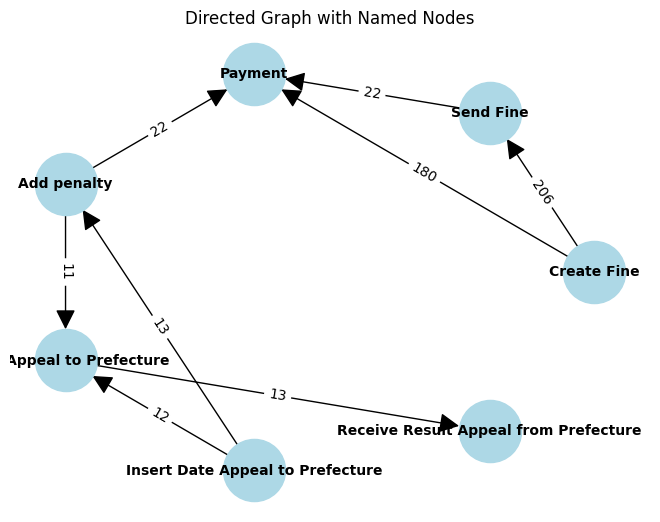

In [287]:
import numpy as np
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Матрица смежности для направленного графа
adjacency_matrix = old_graph

# Словарь с именами вершин
node_names = {0: 'Create Fine', 1: 'Send Fine', 2: 'Insert Fine Notification', 3: 'Add penalty', 4: 'Send for Credit Collection', 5: 'Payment', 
              6: 'Insert Date Appeal to Prefecture', 7: 'Send Appeal to Prefecture', 8: 'Receive Result Appeal from Prefecture', 
              9: 'Notify Result Appeal to Offender', 10: 'Appeal to Judge', 11: 'start', 12: 'end'}

# Создание направленного графа
G = nx.DiGraph()

# Добавление рёбер и их весов из матрицы смежности
for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix)):
        if adjacency_matrix[i][j] > 10:  # Ребро существует
            G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix[i][j])

# Устанавливаем фиксированные позиции для указанных вершин
pos = nx.circular_layout(G)

# Рисование графа
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_weight='bold', 
        arrowsize=30, font_size=10, edge_color='black')

# Добавление весов рёбер как меток
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

# Показ графа
plt.title("Directed Graph with Named Nodes")
plt.show()

### Новый предсказанный граф

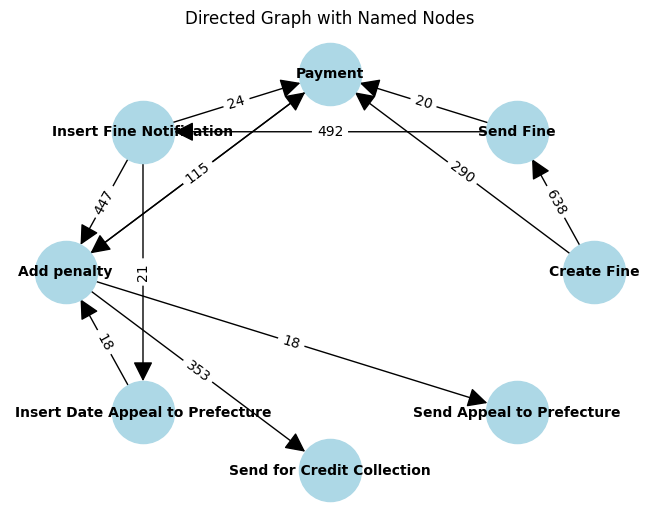

In [289]:
import numpy as np
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Матрица смежности для направленного графа
adjacency_matrix = new_graph

# Словарь с именами вершин
node_names = {0: 'Create Fine', 1: 'Send Fine', 2: 'Insert Fine Notification', 3: 'Add penalty', 4: 'Send for Credit Collection', 5: 'Payment', 
              6: 'Insert Date Appeal to Prefecture', 7: 'Send Appeal to Prefecture', 8: 'Receive Result Appeal from Prefecture', 
              9: 'Notify Result Appeal to Offender', 10: 'Appeal to Judge', 11: 'start', 12: 'end'}

# Создание направленного графа
G = nx.DiGraph()

# Добавление рёбер и их весов из матрицы смежности
for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix)):
        if adjacency_matrix[i][j] > 10:  # Ребро существует
            G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix[i][j])

# Устанавливаем фиксированные позиции для указанных вершин
pos = nx.circular_layout(G)

# Рисование графа
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_weight='bold', 
        arrowsize=30, font_size=10, edge_color='black')

# Добавление весов рёбер как меток
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

# Показ графа
plt.title("Directed Graph with Named Nodes")
plt.show()

In [325]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Матрица смежности для направленного графа
all_adjacency_matrix = np.load('dfg_time_matrix_RTFMP_equitemp.npy')
adjacency_matrix1 = old_graph
adjacency_matrix2 = new_graph

# Словарь с именами вершин
node_names = {0: 'Create Fine', 1: 'Send Fine', 2: 'Insert Fine Notification', 3: 'Add penalty', 4: 'Send for Credit Collection',
 5: 'Payment', 6: 'Insert Date Appeal to Prefecture', 7: 'Send Appeal to Prefecture', 8: 'Receive Result Appeal from Prefecture',
 9: 'Notify Result Appeal to Offender', 10: 'Appeal to Judge', 11: 'start', 12: 'end'}

# Создание направленного графа
G = nx.DiGraph()

# Добавление рёбер и их весов из первой матрицы смежности
edges1 = []
for i in range(len(adjacency_matrix1)):
    for j in range(len(adjacency_matrix1)):
        if adjacency_matrix1[i][j] >10:  # Ребро существует
            G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix1[i][j])
            edges1.append((node_names[i], node_names[j]))

# Добавление рёбер и их весов из второй матрицы смежности
edges2 = []
for i in range(len(adjacency_matrix2)):
    for j in range(len(adjacency_matrix2)):
        if adjacency_matrix2[i][j] >10:  # Ребро существует
            G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix2[i][j])
            edges2.append((node_names[i], node_names[j]))

# Задание фиксированных позиций для вершин
pos = nx.circular_layout(G)


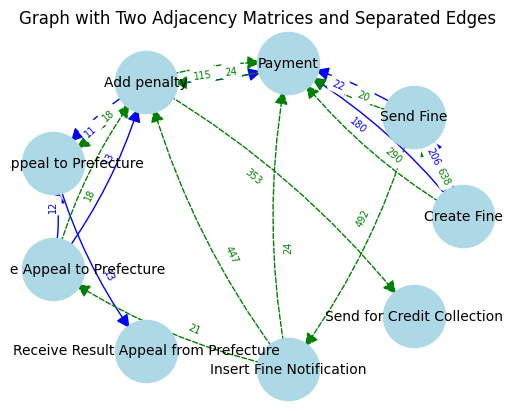

In [327]:
# Рисование узлов
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)

# Рисование рёбер для первой матрицы на уровне 0.1
nx.draw_networkx_edges(G, pos, edgelist=edges1, edge_color='blue', connectionstyle='arc3,rad=0.1', arrowsize=20, 
                       min_source_margin=15, min_target_margin=20)

# Рисование рёбер для второй матрицы на уровне -0.1
nx.draw_networkx_edges(G, pos, edgelist=edges2, edge_color='green', connectionstyle='arc3,rad=-0.1', arrowsize=20, style='dashed',
                       min_source_margin=15, min_target_margin=20)

# Рисование меток узлов
nx.draw_networkx_labels(G, pos, labels={k: k for k in G.nodes()}, font_size=10, font_color='black')

# Добавление весов рёбер из первой матрицы
edge_labels1 = {(node_names[i], node_names[j]): adjacency_matrix1[i][j]
                for i in range(len(adjacency_matrix1)) for j in range(len(adjacency_matrix1)) if adjacency_matrix1[i][j] > 10}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels1, font_color='blue', label_pos=0.4, font_size=7)

# Добавление весов рёбер из второй матрицы
edge_labels2 = {(node_names[i], node_names[j]): adjacency_matrix2[i][j]
                for i in range(len(adjacency_matrix2)) for j in range(len(adjacency_matrix2)) if adjacency_matrix2[i][j] > 10}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels2, font_color='green', label_pos=0.6, font_size=7)

# Показ графа
plt.axis('off')
plt.title("Graph with Two Adjacency Matrices and Separated Edges")
plt.show()